#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, pandas, scikit-learn (only for data processing), pytorch, and ClearML.**
2. Show all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. Check canvas for detail instructions for the report. 
4. Below are the questions/steps that you need to answer. Add as many cells as needed. 

In [1]:
import os
import shutil
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split,Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

## Step 1: Data Processing
1. Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.
2. Estimate mean and variance from the training data for normalization.
3. Create "transforms" for training and test for normalization and data augmentation. 
4. Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.
5. Partition the training dataset further into training and validation
6. Use dataloder to partition and generate minibatches.
7. Visualize input and output for two sample images.

#### 1.Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.
#### Answer- Done manually by creating separate folders for training and test.

#### 2.Estimate mean and variance from the training data for normalization.

In [2]:
#Answer
temp_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder('train', transform=temp_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mean = 0.0
std = 0.0
total_samples = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Batch size (number of images)
    images = images.view(batch_samples, images.size(1), -1)  # Flatten height/width
    mean += images.mean(2).sum(0)  # Sum mean of all pixels in channels
    std += images.std(2).sum(0)    # Sum std deviation of all pixels in channels
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.5077, 0.5077, 0.5077]), Std: tensor([0.2119, 0.2119, 0.2119])


#### 3.Create "transforms" for training and test for normalization and data augmentation.

In [3]:
#Answer
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomRotation(10),        
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


#### 4.Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.

In [4]:
#Answer
train_dataset = datasets.ImageFolder('train', transform=transform_train)
test_dataset = datasets.ImageFolder('test', transform=transform_test)

#### 5.Partition the training dataset further into training and validation 

In [5]:
#Answer
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

#### 6.Use dataloder to partition and generate minibatches.

In [6]:
#Answer
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### 7.Visualize input and output for two sample images.

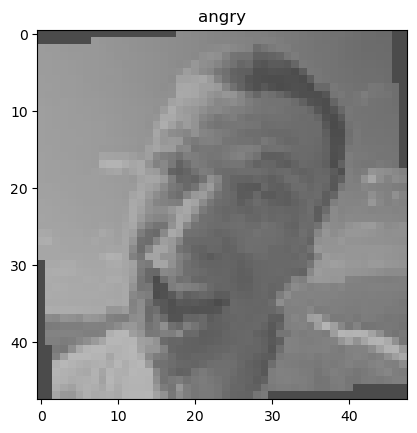

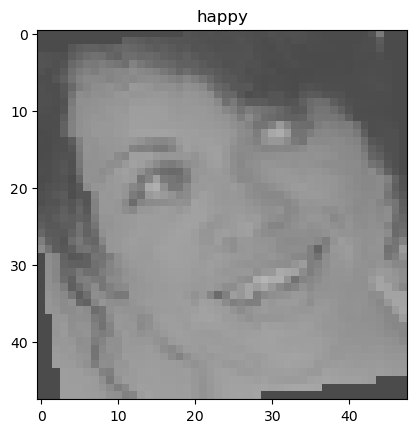

In [7]:
#Answer
def imshow(img, title):
    img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert from CxHxW to HxWxC
    plt.title(title)
    plt.show()

# Get two sample images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Visualize the first two images
for i in range(2):
    imshow(images[i], title=train_dataset.classes[labels[i]])

## Step 2: initial network
1. Create a convolutional neural network. Make the hyper-parameters that you want to tune (e.g., number of layers) dynamic so that you can change them without altering the code. You can choose additional hyperparameters but the followings must be considered.
   1. Number of filters
   2. Number of layers
   3. learning rate
   4. Optimization algorithm specific hyper-paramters, e.g., momentum, for SGD.
   5. weight decay. 
3. Select two images. Pick a configuation of NN and hyperparamters and train to overfit the samples, i.e., the accuracy will be 100%. If the network does not overfit, try differnt hyperparamter configuration, e.g., number of paramters, learning rate.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

# Define the CNN class
class DynamicCNN(nn.Module):
    def __init__(self, num_classes=7, num_layers=3, filters=[32, 64, 128], kernel_size=3):
        super(DynamicCNN, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 1  # Grayscale input
        
        for i in range(num_layers):
            self.layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=filters[i],
                    kernel_size=kernel_size,
                    stride=1,
                    padding=1
                )
            )
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = filters[i]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(filters[-1] * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.fc(x)
        return x

# Define a function to create and train the model
def train_model(num_layers, filters, learning_rate, weight_decay, optimizer_name, momentum=None):
    # Define the model
    model = DynamicCNN(num_layers=num_layers, filters=filters)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if optimizer_name == "SGD":
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "Adam":
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

    return model

# Example usage
model = train_model(
    num_layers=3,
    filters=[32, 64, 128],
    learning_rate=0.001,
    weight_decay=1e-4,
    optimizer_name="SGD",
    momentum=0.9
)


Epoch [1/10], Loss: 1.8769
Epoch [2/10], Loss: 1.8111
Epoch [3/10], Loss: 1.7957
Epoch [4/10], Loss: 1.7790
Epoch [5/10], Loss: 1.7687
Epoch [6/10], Loss: 1.7538
Epoch [7/10], Loss: 1.7401
Epoch [8/10], Loss: 1.7289
Epoch [9/10], Loss: 1.7146
Epoch [10/10], Loss: 1.7044
Validation Loss: 1.6915, Accuracy: 33.56%


In [9]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder('train', transform=transform)

# Select two samples
sample_indices = [0, 1]  # Replace with indices of your choice
subset = Subset(dataset, sample_indices)
loader = DataLoader(subset, batch_size=2, shuffle=True)

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss, and optimizer
model = SimpleCNN(num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0)

# Training loop
epochs = 100  # Train until overfitting
for epoch in range(epochs):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Check accuracy on the two samples
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Stop training if the model overfits
    if correct == total:
        print("The model has overfitted on the two samples.")
        break


Epoch 1/100, Loss: 1.9968, Accuracy: 100.00%
The model has overfitted on the two samples.


## Step 3: ClearML base task
Now train your network with ClearML by creating a task and connecting the parameters to the task. Copy the plots from ClearML and upload them here.

#### if you don't have clearml library installed.
pip install clearml


In [10]:
%pip install --upgrade xgboost clearml
import clearml
clearml.browser_login()

Note: you may need to restart the kernel to use updated packages.


In [11]:
from clearml import Task

In [17]:
from clearml import Task

# Close any active task
if Task.current_task():
    Task.current_task().close()

# Initialize ClearML task
task = Task.init(project_name="Emotion Detection", task_name="Overfitting on Two Samples")

# Hyperparameters
hyperparams = {
    "learning_rate": 0.1,
    "momentum": 0.9,
    "weight_decay": 0.0,
    "num_epochs": 100,
    "batch_size": 2
}
task.connect(hyperparams)

# Load and preprocess dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder('train', transform=transform)
sample_indices = [0, 1]  # Replace with indices of your choice
subset = Subset(dataset, sample_indices)
loader = DataLoader(subset, batch_size=hyperparams["batch_size"], shuffle=True)

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss, and optimizer
model = SimpleCNN(num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=hyperparams["learning_rate"],
    momentum=hyperparams["momentum"],
    weight_decay=hyperparams["weight_decay"]
)

# Training loop
for epoch in range(hyperparams["num_epochs"]):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Log metrics to ClearML
    task.get_logger().report_scalar("Loss", "Train", running_loss / len(loader), epoch)
    task.get_logger().report_scalar("Accuracy", "Train", 100 * correct / total, epoch)

    print(f"Epoch {epoch+1}/{hyperparams['num_epochs']}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Stop training if the model overfits
    if correct == total:
        print("The model has overfitted on the two samples.")
        break

# Finalize task
task.close()


Password protected Jupyter Notebook server was found! Add `sdk.development.jupyter_server_password=<jupyter_password>` to ~/clearml.conf


ClearML Task: overwriting (reusing) task id=61a90356628743568f698278ce8472b5
ClearML results page: https://app.clear.ml/projects/3962a2d2a8fe4bc6826fafb8c0f80a5d/experiments/61a90356628743568f698278ce8472b5/output/log
Epoch 1/100, Loss: 1.8703, Accuracy: 100.00%
The model has overfitted on the two samples.
